In [1]:
# LB Score = 0.83793

# version 1.3
# Added Total damage feature

In [2]:
from scipy.sparse import hstack
import time
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
import ujson as json
from tqdm import tqdm_notebook

In [3]:
def prepare_submit(model, x_test, file_name = 'submission'):
    y_test_pred= model.predict_proba(X_test)[:, 1]
    df_submission = pd.DataFrame({'radiant_win_prob': y_test_pred}, 
                                 index=df_test_features.index)
    df_submission.to_csv(file_name)

In [4]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None, silent = False):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        if (not silent) : print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 2000)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:20].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 10));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [5]:
train = pd.read_csv('../data/train_features.csv', index_col='match_id_hash')
target = pd.read_csv('../data/train_targets.csv', index_col='match_id_hash')
test = pd.read_csv('../data/test_features.csv', index_col='match_id_hash')

In [6]:
split_index = train.shape[0]

In [7]:
df = pd.concat([train, test], sort=False)

In [8]:
df.shape

(49675, 245)

In [9]:
new_features = pd.DataFrame()

In [10]:
r_kills_columns = [col for col in df if col.endswith('kills')][:5]
d_kills_columns = [col for col in df if col.endswith('kills')][5:]
new_features['r_kills_mean'] = df[r_kills_columns].mean(axis = 1)
new_features['r_kills_std'] = df[r_kills_columns].std(axis = 1)
new_features['r_kills_total'] = df[r_kills_columns].sum(axis = 1)
new_features['d_kills_mean'] = df[d_kills_columns].mean(axis = 1)
new_features['d_kills_std'] = df[d_kills_columns].std(axis = 1)
new_features['d_kills_total'] = df[d_kills_columns].sum(axis = 1)
new_features['kills_diff'] = new_features['d_kills_total'] - new_features['r_kills_total']

In [11]:
r_gold_columns = [col for col in df if col.endswith('gold')][:5]
d_gold_columns = [col for col in df if col.endswith('gold')][5:]
new_features['r_gold_mean'] = df[r_gold_columns].mean(axis = 1)
new_features['r_gold_std'] = df[r_gold_columns].std(axis = 1)
new_features['r_gold_total'] = df[r_gold_columns].sum(axis = 1)
new_features['d_gold_mean'] = df[d_gold_columns].mean(axis = 1)
new_features['d_gold_std'] = df[d_gold_columns].std(axis = 1)
new_features['d_gold_total'] = df[d_gold_columns].sum(axis = 1)
#new_features['gold_prop'] = new_features['d_gold_total'] / new_features['r_gold_total']
new_features['gold_prop1'] = new_features['r_gold_total'] / new_features['d_gold_total']

In [12]:
r_stuns_columns = [col for col in df if col.endswith('stuns')][:5]
d_stuns_columns = [col for col in df if col.endswith('stuns')][5:]
new_features['r_stuns_total'] = df[r_stuns_columns].sum(axis = 1) + 1
new_features['d_stuns_total'] = df[d_stuns_columns].sum(axis = 1) + 1

In [13]:
r_max_health_columns = [col for col in df if col.endswith('max_health')][:5]
d_max_health_columns = [col for col in df if col.endswith('max_health')][5:]
new_features['d_max_health_total'] = df[r_max_health_columns].sum(axis = 1)
new_features['r_max_health_total'] = df[d_max_health_columns].sum(axis = 1)
new_features['max_health_prop'] = new_features['r_max_health_total'] / new_features['d_max_health_total']

In [14]:
r_max_mana_columns = [col for col in df if col.endswith('max_mana')][:5]
d_max_mana_columns = [col for col in df if col.endswith('max_mana')][5:]
new_features['d_max_mana_total'] = df[r_max_mana_columns].sum(axis = 1)
new_features['r_max_mana_total'] = df[d_max_mana_columns].sum(axis = 1)
new_features['max_mana_prop'] = new_features['r_max_mana_total'] / new_features['d_max_mana_total']

In [15]:
new_features['d_xp_total'] = df[[col for col in df if col.endswith('xp')][:5]].sum(axis = 1) + 1
new_features['r_xp_total'] = df[[col for col in df if col.endswith('xp')][5:]].sum(axis = 1) + 1

In [16]:
new_features['d_xp_std'] = df[[col for col in df if col.endswith('xp')][:5]].std(axis = 1)
new_features['r_xp_std'] = df[[col for col in df if col.endswith('xp')][5:]].std(axis = 1)

In [17]:
#new_features['total_xp_ratio'] = new_features['d_xp_total'] / new_features['r_xp_total']
new_features['total_xp_ratio1'] = new_features['r_xp_total'] / new_features['d_xp_total']

In [18]:
new_features['d_obs_total'] = df[[col for col in df if col.endswith('obs_placed')][:5]].sum(axis = 1)
new_features['r_obs_total'] = df[[col for col in df if col.endswith('obs_placed')][5:]].sum(axis = 1)
#new_features['obs_prop'] = new_features['d_obs_total']/ new_features['r_obs_total']

In [19]:
r_towers_killed_columns = [col for col in df if col.endswith('towers_killed')][:5]
d_towers_killed_columns = [col for col in df if col.endswith('towers_killed')][5:]
new_features['d_towers'] = df[d_towers_killed_columns].sum(axis = 1) + 1
new_features['r_towers'] = df[r_towers_killed_columns].sum(axis = 1) + 1
new_features['towers_prop'] = new_features['d_towers'] / new_features['r_towers']

In [20]:
r_level_columns = [col for col in df if col.endswith('level')][:5]
d_level_columns = [col for col in df if col.endswith('level')][5:]
new_features['r_max_level'] = df[r_level_columns].max(axis = 1)
new_features['d_max_level'] = df[d_level_columns].max(axis = 1)
new_features['max_level_prop'] = new_features['d_max_level'] / new_features['r_max_level']

In [21]:
new_features['r_mean_level'] = df[r_level_columns].mean(axis = 1)
new_features['d_mean_level'] = df[d_level_columns].mean(axis = 1)
#new_features['mean_level_prop'] = new_features['r_mean_level'] / new_features['d_mean_level']

In [22]:
new_features['r_min_level'] = df[r_level_columns].min(axis = 1)
new_features['d_min_level'] = df[d_level_columns].min(axis = 1)
#new_features['min_level_prop'] = new_features['r_min_level'] / new_features['d_min_level']

In [23]:
r_roshans_killes_columns = [col for col in df if col.endswith('roshans_killed')][:5]
d_roshans_killes_columns = [col for col in df if col.endswith('roshans_killed')][5:]
new_features['r_roshans'] = df[r_roshans_killes_columns].sum(axis = 1) + 1
new_features['d_roshans'] = df[d_roshans_killes_columns].sum(axis = 1) + 1
#new_features['roshans_prop'] = new_features['r_roshans'] / new_features['d_roshans']

In [24]:
r_x_columns = [col for col in df if col.endswith('x')][:5]
d_x_columns = [col for col in df if col.endswith('x')][5:]

In [25]:
new_features['r_x_mean'] = df[r_x_columns].mean(axis = 1)
new_features['d_x_mean'] = df[d_x_columns].mean(axis = 1)
new_features['r_x_max'] = df[r_x_columns].max(axis = 1)
new_features['d_x_max'] = df[d_x_columns].max(axis = 1)
new_features['r_x_min'] = df[r_x_columns].min(axis = 1)
new_features['d_x_min'] = df[d_x_columns].min(axis = 1)

In [26]:
r_y_columns = [col for col in df if col.endswith('y')][:5]
d_y_columns = [col for col in df if col.endswith('y')][5:]

In [27]:
new_features['r_y_mean'] = df[r_y_columns].mean(axis = 1)
new_features['d_y_mean'] = df[d_y_columns].mean(axis = 1)

In [28]:
new_features['r_y_max'] = df[r_y_columns].max(axis = 1)
new_features['d_y_max'] = df[d_y_columns].max(axis = 1)
new_features['r_y_min'] = df[r_y_columns].min(axis = 1)
new_features['d_y_min'] = df[d_y_columns].min(axis = 1)

In [29]:
# coordinates of radiant start point
r_x_min = df[['r1_x', 'r2_x','r3_x','r4_x','r5_x']].min(axis = 1)
r_y_min = df[['r1_y', 'r2_y','r3_y','r4_y','r5_y']].min(axis = 1)

In [30]:
r_x_max = df[['r1_x', 'r2_x','r3_x','r4_x','r5_x']].max(axis = 1)
r_y_max = df[['r1_y', 'r2_y','r3_y','r4_y','r5_y']].max(axis = 1)

In [31]:
new_features['r1_dist'] = np.sqrt((df['r1_y'] - r_y_min)**2 + (df['r1_x'] - r_x_min)**2)
new_features['r2_dist'] = np.sqrt((df['r2_y'] - r_y_min)**2 + (df['r2_x'] - r_x_min)**2)
new_features['r3_dist'] = np.sqrt((df['r3_y'] - r_y_min)**2 + (df['r3_x'] - r_x_min)**2)
new_features['r4_dist'] = np.sqrt((df['r4_y'] - r_y_min)**2 + (df['r4_x'] - r_x_min)**2)
new_features['r5_dist'] = np.sqrt((df['r5_y'] - r_y_min)**2 + (df['r5_x'] - r_x_min)**2)

In [32]:
r_avg_dist = new_features[['r1_dist', 'r2_dist', 'r3_dist', 'r4_dist', 'r5_dist']].mean(axis = 1)

In [33]:
new_features['d1_dist'] = np.sqrt((df['d1_y'] - r_y_max)**2 + (df['d1_x'] - r_x_max)**2)
new_features['d2_dist'] = np.sqrt((df['d2_y'] - r_y_max)**2 + (df['d2_x'] - r_x_max)**2)
new_features['d3_dist'] = np.sqrt((df['d3_y'] - r_y_max)**2 + (df['d3_x'] - r_x_max)**2)
new_features['d4_dist'] = np.sqrt((df['d4_y'] - r_y_max)**2 + (df['d4_x'] - r_x_max)**2)
new_features['d5_dist'] = np.sqrt((df['d5_y'] - r_y_max)**2 + (df['d5_x'] - r_x_max)**2)

In [34]:
d_avg_dist = new_features[['d1_dist', 'd2_dist', 'd3_dist', 'd4_dist', 'd5_dist']].mean(axis = 1)

In [35]:
new_features['dist_prop'] =  d_avg_dist / r_avg_dist

In [36]:
#r_runes = df[[col for col in df if col.endswith('rune_pickups')][:5]].sum(axis = 1) + 1
#d_runes = df[[col for col in df if col.endswith('rune_pickups')][5:]].sum(axis = 1) + 1
#new_features['runes_prop'] = r_runes / d_runes

In [37]:
df.shape

(49675, 245)

In [38]:
#roshan_cols = [col for col in df if col.endswith('roshans_killed')]

In [39]:
#df = df.drop(roshan_cols, axis = 1, inplace = True)

In [40]:
df = pd.concat([df, new_features], axis = 1)

In [41]:
df.shape

(49675, 309)

In [42]:
df.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,r2_dist,r3_dist,r4_dist,r5_dist,d1_dist,d2_dist,d3_dist,d4_dist,d5_dist,dist_prop
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,67.201190,70.000000,100.000000,51.923020,89.106678,66.121101,72.691127,80.224684,50.477718,1.031895
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,88.022724,104.995238,104.804580,101.862653,68.117545,68.000000,38.832976,40.000000,26.000000,0.602851
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,82.219219,66.000000,72.000000,64.000000,41.617304,63.529521,38.832976,39.446166,18.973666,0.593917
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,60.000000,55.605755,58.137767,94.000000,82.097503,51.419841,98.183502,54.000000,94.191295,1.067814
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,72.000000,50.477718,60.000000,96.187317,90.088845,60.000000,60.959003,58.034473,70.114193,0.972764


In [43]:
test_items = pd.read_csv('test_items.csv', index_col='match_id_hash')

In [44]:
train_items = pd.read_csv('train_items.csv', index_col='match_id_hash')

In [45]:
df_items = pd.concat([train_items, test_items])

In [46]:
df = pd.concat([df, df_items], axis = 1)

In [47]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [48]:
df.shape

(49675, 693)

In [49]:
df = df.drop('r1_roshans_killed', axis = 1)
df = df.drop('r2_roshans_killed', axis = 1)
df = df.drop('r3_roshans_killed', axis = 1)
df = df.drop('r4_roshans_killed', axis = 1)
df = df.drop('r5_roshans_killed', axis = 1)

In [50]:
df = df.drop('d1_roshans_killed', axis = 1)
df = df.drop('d2_roshans_killed', axis = 1)
df = df.drop('d3_roshans_killed', axis = 1)
df = df.drop('d4_roshans_killed', axis = 1)
df = df.drop('d5_roshans_killed', axis = 1)

In [51]:
df.shape

(49675, 683)

In [52]:
train = df[:split_index].copy()
test = df[split_index:].copy()

In [53]:
train.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d_item_urn_of_shadows,d_item_vanguard,d_item_veil_of_discord,d_item_vitality_booster,d_item_vladmir,d_item_void_stone,d_item_ward_dispenser,d_item_wind_lace,d_item_wraith_band,d_item_yasha
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
train['radiant_win'] = target['radiant_win']

Fold 0 started at Sun Oct 13 05:39:53 2019
Training until validation scores don't improve for 2000 rounds
[1000]	training's auc: 0.879343	valid_1's auc: 0.82127
[2000]	training's auc: 0.925363	valid_1's auc: 0.826476
[3000]	training's auc: 0.956157	valid_1's auc: 0.828477
[4000]	training's auc: 0.976018	valid_1's auc: 0.829106
[5000]	training's auc: 0.988046	valid_1's auc: 0.829349
[6000]	training's auc: 0.994608	valid_1's auc: 0.829204
Early stopping, best iteration is:
[4656]	training's auc: 0.984636	valid_1's auc: 0.829462
Fold 1 started at Sun Oct 13 05:40:24 2019
Training until validation scores don't improve for 2000 rounds
[1000]	training's auc: 0.881891	valid_1's auc: 0.80962
[2000]	training's auc: 0.927361	valid_1's auc: 0.814021
[3000]	training's auc: 0.957454	valid_1's auc: 0.815965
[4000]	training's auc: 0.976608	valid_1's auc: 0.816378
[5000]	training's auc: 0.988269	valid_1's auc: 0.816455
[6000]	training's auc: 0.994533	valid_1's auc: 0.816527
[7000]	training's auc: 0.99

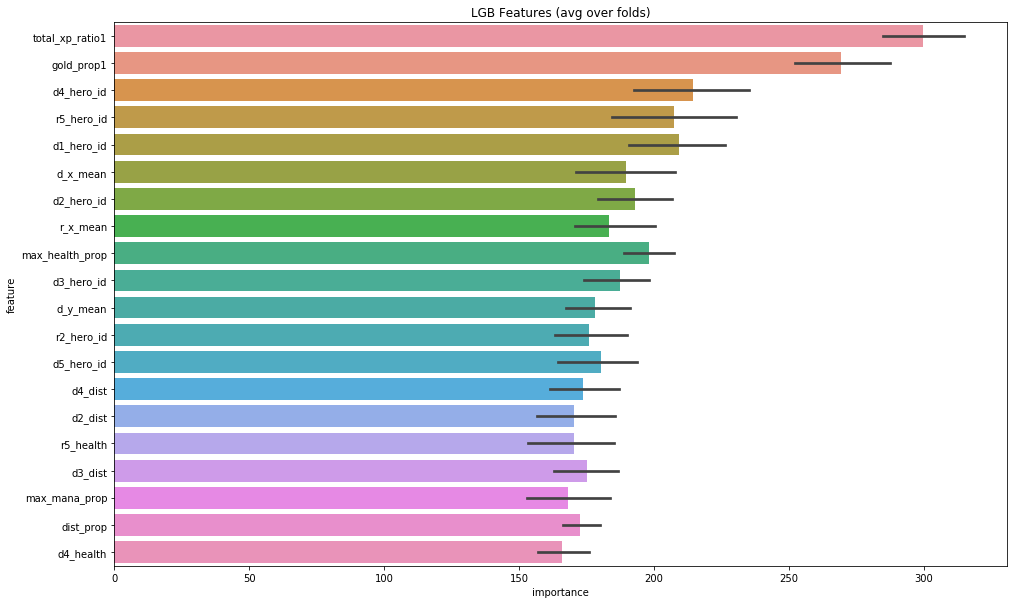

In [55]:
params = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': -1,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'objective': 'binary'
         }

X = train.drop(['radiant_win'], axis=1).reset_index(drop=True)
y = target['radiant_win']
X_test = test.reset_index(drop=True)

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True, silent = False)

In [56]:
# CV mean score: 0.8246, std: 0.0058

In [57]:
# CV mean score: 0.8247, std: 0.0055

In [58]:
# CV mean score: 0.8245, std: 0.0055 - drop R1_roshans_killed

In [59]:
# CV mean score: 0.8222, std: 0.0104

In [60]:
prediction_lgb

array([0.5463043 , 0.99318705, 0.96148037, ..., 0.48704233, 0.82171963,
       0.05766455])

In [61]:
oof_lgb

array([0.16407808, 0.96560349, 0.53759222, ..., 0.07155057, 0.88197511,
       0.72697807])

In [62]:
df_submission = pd.DataFrame({'radiant_win_prob': prediction_lgb}, 
                                 index=test.index)
df_submission.to_csv('Submission4_LBG_items.csv')

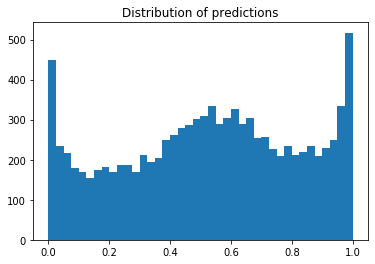

In [63]:
plt.hist(prediction_lgb, bins=40);
plt.title('Distribution of predictions');